In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import os
from datetime import datetime
from matplotlib import pyplot as plt
root=os.getcwd()

  # Capstone Project - Location Recommendation for Job Searcher

Whether you are a fresh graduate looking for your first job or you are an experienced professional looking for a move, the first question you always ask is which job title(s) matches my skill set so that I can use it to search on the job-search engine? and which locations give me the most job opportunities for the title?

These two questions are answered in this Capstone Project and check this ML model with my website: whereisyournextjob.com

The project includes two parts: job description classification to match skill sets with job titles, and job opening prediction in each states for different occupation titles.



#     Part 1: Job Description Classification

## 1.1 Data Scraping and Clean up
The job descriptions are scraped from Monster.com with key words of different engineering titles. The scraping file is "Monster_engineer_jobs_scraping.py". The following engineering categories are considered:

     Aerospace Engineer

     Biomedical Engineer

     Chemical Engineer

     Civil Engineer

     Computer Hardware Engineer

     Electrical Engineer

     Electronics Engineer

     Environmental Engineer

     Health and Safety Engineer

     Industrial Engineer

     Material Engineer

     Mechanical Engineer
 
Each category has about 2000 record.

In [3]:
#path=os.getcwd()
eng_titles = {0:'Aerospace',1:'Biomedical', 2:'Chemical', 3: 'Civil', 4:'Computer-Hardware', 
              5:'Electrical', 6:'Electronics', 7:'Environmental', 8:'Health-and-Safety',
              9:'Industrial', 10:'Material', 11:'Mechanical'}

total_category = len(eng_titles)
JD = []
JT = []
labels = []
for key, value in eng_titles.items():
    filename = root+'/monster_JD/new_sen/'+ value +'_jobs.csv'
    data = pd.read_csv(filename,header = 0,sep=',',quotechar='"') 
    JD.extend(list(data.Job_Description))
    JT.extend(list(data.Job_title))
    labels.extend([eng_titles[key]+' Engineer']*len(list(data.Job_title)))

In [4]:
print('Number of record for each category: ')
for key, value in eng_titles.items():
    print('    Record of {} Engineer: {}'.format(value, len([item for item in labels if item == value + ' Engineer'])))

Number of record for each category: 
    Record of Aerospace Engineer: 1875
    Record of Biomedical Engineer: 2150
    Record of Chemical Engineer: 2148
    Record of Civil Engineer: 2145
    Record of Computer-Hardware Engineer: 2137
    Record of Electrical Engineer: 2150
    Record of Electronics Engineer: 2147
    Record of Environmental Engineer: 2148
    Record of Health-and-Safety Engineer: 2149
    Record of Industrial Engineer: 1943
    Record of Material Engineer: 2126
    Record of Mechanical Engineer: 2149


## Cleanup Data
Find those records that are not in the right format, ie, mess data. As only 559 of 25267 (2.2%) of the records are messy, it is ok to remove them for easy handling of the data. 

The rest of the job description is then parsed with regex, remove the tags, punctuation, unicode, url, email etc.

In [5]:
import re
print(len(JD))
mess_record_list = []
for ind,desp in enumerate(JD):
    if re.findall(r'"companyInfo"', desp):
        mess_record_list.append(ind)
print(len(mess_record_list), len(mess_record_list)/len(JD))

25267
559 0.022123718684450074


In [6]:
JD = [item for (ind,item) in enumerate(JD) if ind not in mess_record_list]
JT = [item for (ind,item) in enumerate(JT) if ind not in mess_record_list]
labels = [item for (ind,item) in enumerate(labels) if ind not in mess_record_list]

In [7]:
import re
import unicodedata

# add parsing for unicode, delete them
def standardize_text(desp):
    desp = re.sub(r"#TrackingJobBody p{margin:5px 0px; }","",desp)  # replace end of JD html format
    sents = re.split('\n|\?|\!|\;|\:',desp) 
    temp =[]
    for sent in sents:
        sent = unicodedata.normalize("NFKD", sent)        
        sent = re.sub(r"http\S+", "", sent)  # replace url
        sent = re.sub(r"www\S+", "", sent)  # replace url
        sent = re.sub(r"\S+@\S+", "",sent)  # replace email @
        sent = re.sub(r"[^A-Za-z0-9&\'\`\"\_\-]", " ", sent)
        sent = re.sub(r"@", "at", sent) 
        sent = ' '.join(list(filter(lambda word: word !='' , re.split(' ',sent))))
        if len(sent) >1:
            temp.append(sent)
    return ' '.join(temp)

In [8]:
new_JD = [standardize_text(desp) for desp in JD]

In [9]:
additional_mess_data =[]
for ind,desp in enumerate(new_JD):
    if re.findall(r'0px', desp):
        additional_mess_data.append(ind)
len(additional_mess_data)

28

In [10]:
JD = [item for (ind,item) in enumerate(new_JD) if ind not in additional_mess_data]
JT = [item for (ind,item) in enumerate(JT) if ind not in additional_mess_data]
labels = [item for (ind,item) in enumerate(labels) if ind not in additional_mess_data]
len(JD),len(JT), len(labels)

(24680, 24680, 24680)

Number of record for each category:

    Record of Aerospace Engineer: 1875  ->  1850
    
    Record of Biomedical Engineer: 2150  -> 2133
    
    Record of Chemical Engineer: 2148  ->2078
    
    Record of Civil Engineer: 2145 ->2116
    
    Record of Computer-Hardware Engineer: 2137 -> 2113
    
    Record of Electrical Engineer: 2150 -> 2083
    
    Record of Electronics Engineer: 2147 -> 2067
    
    Record of Environmental Engineer: 2148 -> 2133 - > 2114
    
    Record of Health-and-Safety Engineer: 2149 -> 2071 -> 2064
    
    Record of Industrial Engineer: 1943 -> 1883 -> 1881
    
    Record of Material Engineer: 2126 -> 2079
    
    Record of Mechanical Engineer: 2149 -> 2102

Save the preprocessed data to disk

In [10]:
import dill
dill.dump(JD,open(root+'/monster_JD/dill_folder/JD.dill','wb'))
dill.dump(JT,open(root+ '/monster_JD/dill_folder/JT.dill','wb'))
dill.dump(labels,open(root+'/monster_JD/dill_folder/labels.dill','wb'))

 ## 1.2 Machine Learning Model 
 Use 80-20 train-test split for model validation

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = \
               train_test_split(JD, labels, test_size = 0.2, random_state = 42)

print(len(y_train),len(y_test))
y_train_num=[]
y_test_num = []
for key,value in eng_titles.items():
    y_train_num.append(sum([1 if label ==value +" Engineer" else 0 for label in y_train])) 
    y_test_num.append(sum([1 if label ==value +" Engineer" else 0 for label in y_test])) 
print(y_train_num)
print(y_test_num)

19744 4936
[1492, 1669, 1661, 1692, 1688, 1698, 1652, 1688, 1671, 1511, 1661, 1661]
[358, 464, 417, 424, 425, 385, 415, 426, 393, 370, 418, 441]


In [15]:
filename = root+ '/monster_JD/dill_folder/1vsall'
dill.dump(X_train,open(filename + '_X_train.dill','wb'))
dill.dump(X_test,open(filename + '_X_test.dill','wb'))  
dill.dump(y_train,open(filename + '_y_train.dill','wb'))
dill.dump(y_test,open(filename + '_y_test.dill','wb'))

Use Tfidf Vectorizer to create the NLP features:

There are two ways to perform categorical classification:

    1-vs-1: train models for each pair of category, total of 12*11/2 = 66 models
    
    1-vs-all: train models for each (category i, not category i), total of 12 models

As there is no dominant engineering category and the dataset is balanced for all categories, 1-vs-all method is used for this project

In [11]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re

nlp = spacy.load("en")
def tokenize_lemma(text):
    return re.findall(r'\w+', ' '.join([w.lemma_ for w in nlp(text)]))

stop_words_lemma = set(w.lemma_ for w in nlp(' '.join(STOP_WORDS)))


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

stop_words_lemma = set(w.lemma_ for w in nlp(' '.join(STOP_WORDS)))

tfidf_unigram = TfidfVectorizer(ngram_range = (1,1),#max_features = 1000,
                            stop_words = stop_words_lemma,
                            tokenizer = tokenize_lemma)

tfidf_bigram = TfidfVectorizer(ngram_range = (1,2),#max_features = 1000,
                            stop_words = stop_words_lemma,
                            tokenizer = tokenize_lemma)

X_train_counts_uni = tfidf_unigram.fit_transform(X_train)
X_train_counts_bi = tfidf_bigram.fit_transform(X_train)
X_test_counts_uni = tfidf_unigram.transform(X_test)
X_test_counts_bi = tfidf_bigram.transform(X_test)

In [16]:
filename = root+'/monster_JD/dill_folder/1vsall'
dill.dump(tfidf_unigram,open(filename + '_tfidf_unigram.dill','wb'))
dill.dump(tfidf_bigram,open(filename + '_tfidf_bigram.dill','wb'))
dill.dump(X_train_counts_uni,open(filename + '_train_counts_uni.dill','wb'))
dill.dump(X_train_counts_bi,open(filename + '_train_counts_bi.dill','wb'))
dill.dump(X_test_counts_uni,open(filename + '_test_counts_uni.dill','wb'))
dill.dump(X_test_counts_bi,open(filename + '_test_counts_bi.dill','wb'))

In [44]:
X_train_counts_uni.shape, X_train_counts_bi.shape

((19744, 29396), (19744, 529010))

## 1.2.1 MultinomialNB method

In [18]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train_counts_uni,y_train)
y_pred = MNB.predict(X_test_counts_uni)
print('Training accuracy: ', MNB.score(X_train_counts_uni,y_train))
print('Test Accuracy: ', MNB.score(X_test_counts_uni,y_test))

dill.dump(MNB,open(root+'/monster_JD/dill_folder/MNB.dill','wb'))

Training accuracy:  0.7838330632090762
Test Accuracy:  0.7463533225283631


In [49]:
from sklearn.naive_bayes import MultinomialNB

MNB_bi = MultinomialNB()
MNB_bi.fit(X_train_counts_bi,y_train)
y_pred = MNB_bi.predict(X_test_counts_bi)
print('Training accuracy: ', MNB_bi.score(X_train_counts_bi,y_train))
print('Test Accuracy: ', MNB_bi.score(X_test_counts_bi,y_test))

dill.dump(MNB_bi,open(root+'/monster_JD/dill_folder/MNB_bi.dill','wb'))

Training accuracy:  0.85165113452188
Test Accuracy:  0.8030794165316045


### Find the most important features for each category

In [19]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        classes[class_index] = tops
    return classes

In [20]:
import numpy as np
def plot_important_words(word_importances,keys,fname):
    y_pos = np.arange(len(word_importances[keys[0]]))
    
    title1 = eng_titles[keys[0]]
    title1_top_words = [a[1] for a in word_importances[keys[0]]]
    title1_top_scores = [a[0] for a in word_importances[keys[0]]]
    
    title2 = eng_titles[keys[1]]
    title2_top_words = [a[1] for a in word_importances[keys[1]]]
    title2_top_scores = [a[0] for a in word_importances[keys[1]]]
    
    
    title3 = eng_titles[keys[2]]
    title3_top_words = [a[1] for a in word_importances[keys[2]]]
    title3_top_scores = [a[0] for a in word_importances[keys[2]]]
    
   
    fig = plt.figure(figsize=(10, 10))  

    name = 'Most Important Words for Engineers in'
    plt.subplot(131)
    plt.barh(y_pos,title1_top_scores[::-1], align='center', alpha=0.5)
    plt.title(title1, fontsize=20)
    plt.yticks(y_pos, title1_top_words[::-1], fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(132)
    plt.barh(y_pos,title2_top_scores[::-1], align='center', alpha=0.5)
    plt.title(title2, fontsize=20)
    plt.yticks(y_pos, title2_top_words[::-1], fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    
    plt.subplot(133)
    plt.barh(y_pos,title3_top_scores[::-1], align='center', alpha=0.5)
    plt.title(title3, fontsize=20)
    plt.yticks(y_pos, title3_top_words[::-1], fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    plt.savefig(fname,dpi= 'figure')

In [21]:
vectorizer = tfidf_unigram
model = MNB
importance_MNB = get_most_important_features(vectorizer,model,n=10)
importance_MNB

{0: [(-6.569852063256712, 'development'),
  (-6.545614529348791, 'engineer'),
  (-6.485549496546794, 'test'),
  (-6.413561833342893, 'software'),
  (-6.351309628777444, 'design'),
  (-6.32244127683866, 'engineering'),
  (-6.30200026672908, 'experience'),
  (-6.192610629038627, 'system'),
  (-5.977328544218485, 'aerospace'),
  (-5.609780410244924, 'PRON')],
 1: [(-6.539861858676227, 'engineering'),
  (-6.537089871494091, 'work'),
  (-6.506457652170324, 'product'),
  (-6.420064932753534, 'experience'),
  (-6.391311930374406, 'device'),
  (-6.380584775929953, 'equipment'),
  (-6.366652608159157, 'clinical'),
  (-6.1105100662796765, 'medical'),
  (-5.950272641351755, 'PRON'),
  (-5.810856058343258, 'biomedical')],
 2: [(-6.695989337105151, 'engineer'),
  (-6.654850796820402, 'manufacturing'),
  (-6.611946324532309, 'product'),
  (-6.51124671130658, 'work'),
  (-6.425642539507909, 'project'),
  (-6.332763220412673, 'experience'),
  (-6.30255973522832, 'engineering'),
  (-5.729165139797569, 

In [50]:
vectorizer = tfidf_bigram
model = MNB_bi
importance_MNB_bi = get_most_important_features(vectorizer,model,n=10)
importance_MNB_bi

{0: [(-9.666103395986251, 'development'),
  (-9.659323124618236, 'engineer'),
  (-9.584005579011562, 'test'),
  (-9.483052063405603, 'software'),
  (-9.470555322151693, 'design'),
  (-9.431893248747684, 'engineering'),
  (-9.410594963279465, 'experience'),
  (-9.288676192790726, 'system'),
  (-9.091891637563634, 'aerospace'),
  (-8.683065278286065, 'PRON')],
 1: [(-9.6262054272593, 'product'),
  (-9.621779505579878, 'work'),
  (-9.617853115623177, 'biomedical engineering'),
  (-9.513353459259037, 'experience'),
  (-9.490745164018138, 'device'),
  (-9.45537361484195, 'equipment'),
  (-9.40717792315764, 'clinical'),
  (-9.201121764836994, 'medical'),
  (-9.00104781614952, 'PRON'),
  (-8.90733659725483, 'biomedical')],
 2: [(-9.757927926196192, 'manufacturing'),
  (-9.710551025430018, 'product'),
  (-9.607071397290671, 'work'),
  (-9.529187044268028, 'project'),
  (-9.484910663566584, 'chemical engineering'),
  (-9.436055366837675, 'experience'),
  (-9.407460061688182, 'engineering'),
  (

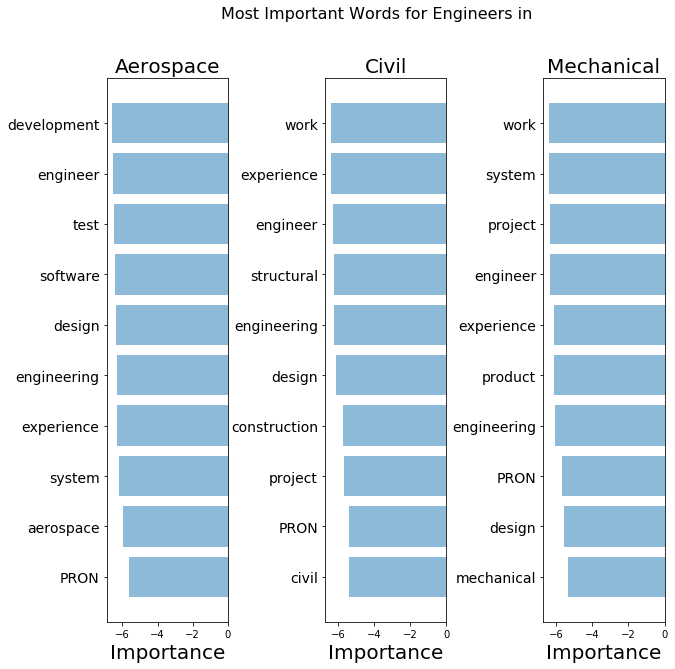

<Figure size 432x288 with 0 Axes>

In [22]:
plot_important_words(importance_MNB, [0,3,11], 'Aero_Civil_Mech_MNB')

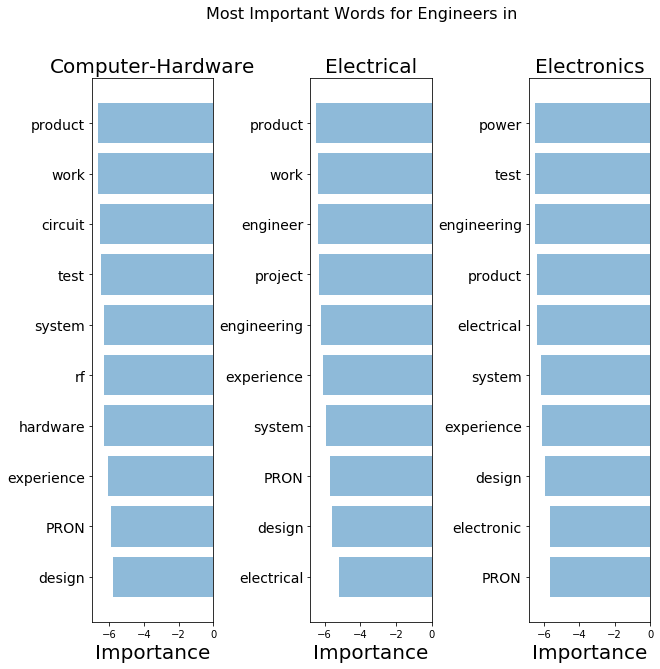

<Figure size 432x288 with 0 Axes>

In [23]:
plot_important_words(importance_MNB, [4,5,6],'hardware_eletrical_electronics_MNB')

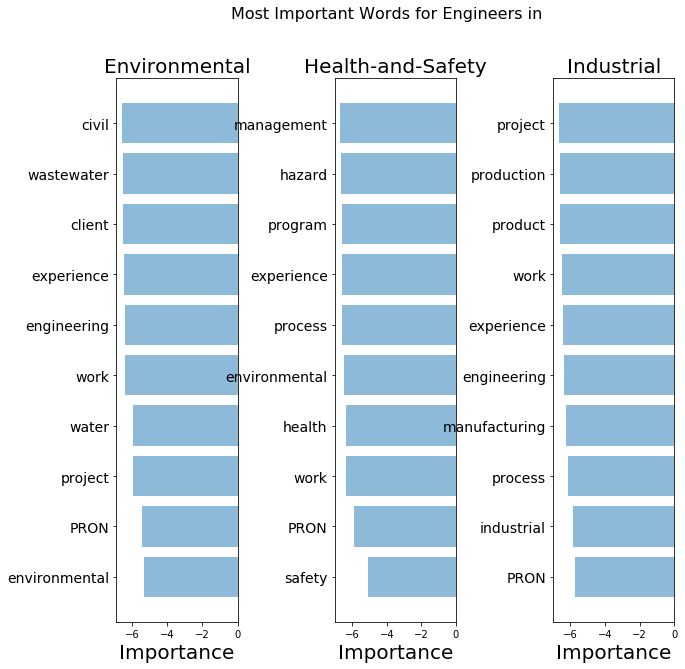

<Figure size 432x288 with 0 Axes>

In [24]:
plot_important_words(importance_MNB, [7,8,9], 'envi_health_indus_MNB')

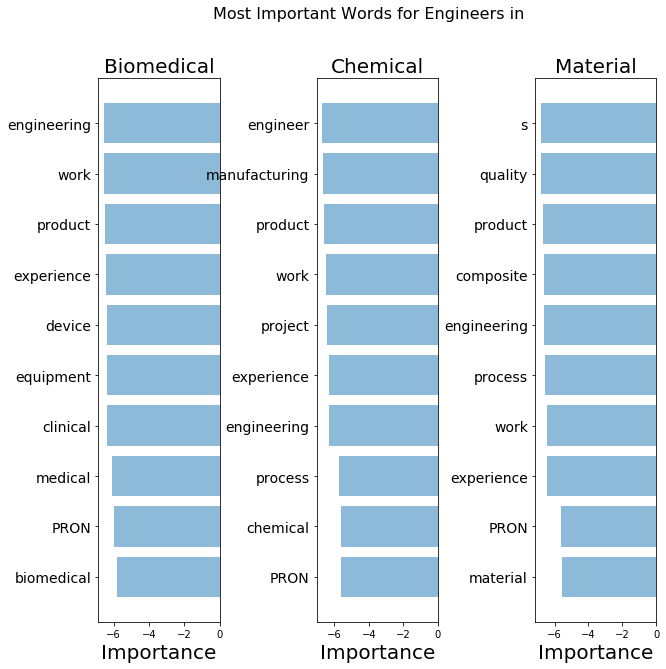

<Figure size 432x288 with 0 Axes>

In [25]:
plot_important_words(importance_MNB, [1,2,10],'biom_chem_material_MNB')

As shown above, the top 10 most important words for each category are not very unique, as "work", "product", "project", "experience" could be shown in all categories. The multinominalNB model does not capture the unique technical skill sets required for each engineer category. 

## 1.2.2 TruncatedSVD + LogisticRegression

Gridsearch to find optimal paramters

Gridsearch parameters on n_components in TruncatedSVD

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(C=30.0,class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

pipe = Pipeline([('LSA',TruncatedSVD() ),
                 ('clf', clf)
                 ])

param_grid = {"LSA__n_components": (50, 100, 200, 300, 400)} # , "clf__C": range(10,60,10)} 

cv_1vsall = GridSearchCV(pipe, param_grid = param_grid, 
                         cv=5, scoring = 'accuracy',
                         return_train_score = True)

cv_unigram1 = cv_1vsall.fit(X_train_counts_uni,y_train)
uni_res = cv_unigram1.cv_results_

uni_mtts = pd.DataFrame.from_dict(
    {'n_components': [rec['LSA__n_components'] for rec in uni_res['params']],
    'mean_test_score': uni_res['mean_test_score']})
uni_mtrs = pd.DataFrame.from_dict(
    {'n_components': [rec['LSA__n_components'] for rec in uni_res['params']],
    'mean_train_score': uni_res['mean_train_score']})

plt.plot(uni_mtts.n_components, uni_mtts.mean_test_score, label="uni_mean_test_score")
plt.plot(uni_mtrs.n_components, uni_mtrs.mean_train_score, label="uni_mean_train_score")
plt.xlabel('n_components')
plt.ylabel('score')
plt.legend(loc='center right')
plt.show()


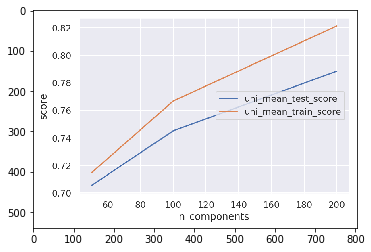

In [29]:
import matplotlib.image as mpimg 
img = mpimg.imread(root +'/monster_JD/Images/GV_n_components_uni.png') 
plt.imshow(img) 

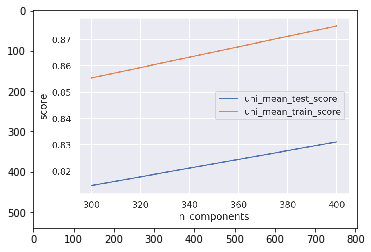

In [30]:
img = mpimg.imread(root+'/monster_JD/Images/GV_n_components_uni_2.png') 
plt.imshow(img)

Gridsearch on parameter C in LogisticRegression

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

pipe = Pipeline([('LSA',TruncatedSVD(n_components = 100) ),
                 ('clf', clf)
                 ])

param_grid = { "clf__C": range(10,70,10)} 

cv_1vsall_2 = GridSearchCV(pipe, param_grid = param_grid, 
                         cv=5, scoring = 'accuracy',
                         return_train_score = True)

cv_unigram = cv_1vsall_2.fit(X_train_counts_uni,y_train)
uni_res = cv_unigram.cv_results_

uni_mtts = pd.DataFrame.from_dict(
    {'C': [rec['clf__C'] for rec in uni_res['params']],
    'mean_test_score': uni_res['mean_test_score']})
uni_mtrs = pd.DataFrame.from_dict(
    {'C': [rec['clf__C'] for rec in uni_res['params']],
    'mean_train_score': uni_res['mean_train_score']})

plt.plot(uni_mtrs.C, uni_mtrs.mean_train_score, label="uni_mean_train_score")
plt.plot(uni_mtts.C, uni_mtts.mean_test_score, label="uni_mean_test_score")

plt.xlabel('C')
plt.ylabel('score')
plt.legend(loc='center right')
plt.show()


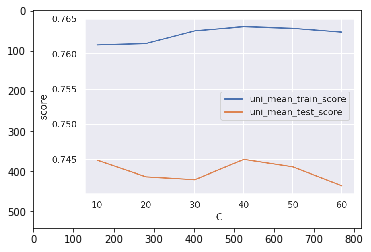

In [31]:
img = mpimg.imread(root +'/monster_JD/Images/GV_C_uni.png') 
plt.imshow(img)

In [33]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_100 = Pipeline([('LSA',TruncatedSVD(n_components = 100) ),
                 ('clf', clf)
                 ])
LR_pipe_100.fit(X_train_counts_uni,y_train)
y_pred = LR_pipe_100.predict(X_test_counts_uni)
print('Training accuracy: ', LR_pipe_100.score(X_train_counts_uni,y_train))
print('Test Accuracy: ', LR_pipe_100.score(X_test_counts_uni,y_test))
dill.dump(LR_pipe_100,open(root+'/monster_JD/dill_folder/LR_pipe_100.dill','wb'))

Training accuracy:  0.7622062398703403
Test Accuracy:  0.7400729335494327


In [34]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_200 = Pipeline([('LSA',TruncatedSVD(n_components = 200) ),
                 ('clf', clf)
                 ])
LR_pipe_200.fit(X_train_counts_uni,y_train)
y_pred = LR_pipe_200.predict(X_test_counts_uni)
print('Training accuracy: ', LR_pipe_200.score(X_train_counts_uni,y_train))
print('Test Accuracy: ', LR_pipe_200.score(X_test_counts_uni,y_test))
dill.dump(LR_pipe_200,open('monster_JD/dill_folder/LR_pipe_1vsall_200.dill','wb'))

Training accuracy:  0.8211102106969206
Test Accuracy:  0.7905186385737439


In [51]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_200_bi = Pipeline([('LSA',TruncatedSVD(n_components = 200) ),
                 ('clf', clf)
                 ])
LR_pipe_200_bi.fit(X_train_counts_bi,y_train)
y_pred = LR_pipe_200_bi.predict(X_test_counts_bi)
print('Training accuracy: ', LR_pipe_200_bi.score(X_train_counts_bi,y_train))
print('Test Accuracy: ', LR_pipe_200_bi.score(X_test_counts_bi,y_test))
dill.dump(LR_pipe_200_bi,open('monster_JD/dill_folder/LR_pipe_1vsall_200_bi.dill','wb'))

Training accuracy:  0.8143233387358185
Test Accuracy:  0.7862641815235009


In [ ]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_200_bi_ex = Pipeline([('LSA',TruncatedSVD(n_components = 200) ),
                 ('clf', clf)
                 ])
LR_pipe_200_bi_ex.fit(X_train_counts_bi_ex,y_train)
y_pred = LR_pipe_200_bi_ex.predict(X_test_counts_bi_ex)
print('Training accuracy: ', LR_pipe_200_bi_ex.score(X_train_counts_bi_ex,y_train))
print('Test Accuracy: ', LR_pipe_200_bi_ex.score(X_test_counts_bi_ex,y_test))
dill.dump(LR_pipe_200_bi_ex,open('monster_JD/dill_folder/LR_pipe_1vsall_200_bi_ex.dill','wb'))

In [35]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_400 = Pipeline([('LSA',TruncatedSVD(n_components = 400) ),
                 ('clf', clf)
                 ])
LR_pipe_400.fit(X_train_counts_uni,y_train)
y_pred = LR_pipe_400.predict(X_test_counts_uni)
print('Training accuracy: ', LR_pipe_400.score(X_train_counts_uni,y_train))
print('Test Accuracy: ', LR_pipe_400.score(X_test_counts_uni,y_test))
dill.dump(LR_pipe_400,open('monster_JD/dill_folder/LR_pipe_1vsall_400.dill','wb'))

Training accuracy:  0.8776843598055105
Test Accuracy:  0.8415721231766613


In [54]:
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe_400_bi= Pipeline([('LSA',TruncatedSVD(n_components = 400) ),
                 ('clf', clf)
                 ])
LR_pipe_400_bi.fit(X_train_counts_bi,y_train)
y_pred = LR_pipe_400_bi.predict(X_test_counts_bi)
print('Training accuracy: ', LR_pipe_400_bi.score(X_train_counts_bi,y_train))
print('Test Accuracy: ', LR_pipe_400_bi.score(X_test_counts_bi,y_test))
dill.dump(LR_pipe_400_bi,open('monster_JD/dill_folder/LR_pipe_1vsall_400_bi.dill','wb'))

Training accuracy:  0.8608691247974068
Test Accuracy:  0.8306320907617504


In [8]:
import numpy as np
def get_most_important_features_svd(vectorizer,svd, model, n=5):

    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    total_words = len(index_to_word)
    classes = {}   
    svd_components = svd.components_

    index_importance = np.matmul(np.transpose(svd_components), np.transpose(model.coef_))

    for class_index in range(model.coef_.shape[0]):
        word_importance = [(weight, index_to_word[ind]) for ind,weight in enumerate(index_importance[:,class_index])]
        sorted_word_imp = sorted(word_importance, key = lambda x: x[0], reverse = True)
        top_words = sorted(sorted_word_imp[:n], key = lambda x:x[0], reverse = True)
        classes[class_index] = top_words
    return classes

In [38]:
vectorizer = tfidf_unigram
svd = LR_pipe_100.named_steps['LSA']
model = LR_pipe_100.named_steps['clf']
importance_LR_100 = get_most_important_features_svd(vectorizer,svd,model,n=10)
importance_LR_100

{0: [(15.319685015103, 'aerospace'),
  (7.867717209280084, 'aircraft'),
  (7.4595590266476135, 'engineer'),
  (7.112282635885367, 'avionic'),
  (6.705924338457858, 'engine'),
  (5.941449020534173, 'flight'),
  (5.699825739401623, 'program'),
  (5.239767838606168, 'terracon'),
  (5.190565099460066, 'customer'),
  (5.130053095631753, 'software')],
 1: [(23.891837109175352, 'biomedical'),
  (13.178227012524843, 'medical'),
  (10.126836089189258, 'clinical'),
  (8.14282333764924, 'equipment'),
  (7.697570807180035, 'device'),
  (7.025590502577243, 'instrumentation'),
  (6.860052358869951, 'research'),
  (6.488150022589367, 'hospital'),
  (6.472811532417838, 'software'),
  (6.397484233461979, 'laboratory')],
 2: [(24.46132754264202, 'chemical'),
  (7.845953931282854, 'chemistry'),
  (7.65544078485212, 'process'),
  (6.574763866792933, 'material'),
  (6.316226901645535, 'environmental'),
  (4.261486506670065, 'safety'),
  (4.174892524397188, 'laboratory'),
  (3.746570228630271, 'guard'),
  (

In [39]:
vectorizer = tfidf_unigram
svd = LR_pipe_200.named_steps['LSA']
model = LR_pipe_200.named_steps['clf']
importance_LR_200 = get_most_important_features_svd(vectorizer,svd,model,n=10)
importance_LR_200

{0: [(21.885658012639787, 'aerospace'),
  (10.784108958841417, 'aircraft'),
  (8.388763716556095, 'flight'),
  (7.763661360019804, 'mechanical'),
  (7.173036202491232, 'development'),
  (7.109043538381329, 'program'),
  (7.0158939063274, 'embed'),
  (6.545560240855223, 'avionic'),
  (6.3670202711714605, 'manufacturing'),
  (6.349714994606241, 'engine')],
 1: [(45.52712195020352, 'biomedical'),
  (13.297166140663133, 'medical'),
  (10.28407552662698, 'hospital'),
  (9.762090268313369, 'instrumentation'),
  (9.029028069806449, 'research'),
  (8.961294604586701, 'clinical'),
  (7.346057812482625, 'equipment'),
  (7.188132435544061, 'ensure'),
  (6.857852586319532, 'purification'),
  (6.631199017034281, 'site')],
 2: [(32.725825567478644, 'chemical'),
  (9.73446301019203, 'chemistry'),
  (7.2813966928437575, 'material'),
  (6.0703012531162255, 'environmental'),
  (5.972631654988306, 'safety'),
  (5.629027080423858, 'scale'),
  (5.600104239477417, 'gas'),
  (5.42588166534098, 'industry'),
 

In [52]:
vectorizer = tfidf_bigram
svd = LR_pipe_200_bi.named_steps['LSA']
model = LR_pipe_200_bi.named_steps['clf']
importance_LR_200_bi = get_most_important_features_svd(vectorizer,svd,model,n=10)
importance_LR_200_bi

{0: [(19.032048703217228, 'aerospace'),
  (10.633851253442382, 'flight'),
  (9.703738638679432, 'aircraft'),
  (8.122233592604847, 'flight test'),
  (7.890215270723858, 'avionic'),
  (7.62817284268473, 'test'),
  (6.7212967597289035, 'engine'),
  (6.6673102672868065, 'software'),
  (6.53213058193368, 'customer'),
  (6.438247282821044, 'engineering')],
 1: [(31.856855494319955, 'biomedical'),
  (14.62143392007376, 'medical'),
  (14.509796381346266, 'clinical'),
  (12.773444741744916, 'biomedical engineering'),
  (10.835271562391531, 'biomedical engineer'),
  (10.418504344018693, 'biomedical equipment'),
  (9.033534924278689, 'hospital'),
  (8.611247545214955, 'device'),
  (8.322835171615244, 'human factor'),
  (8.14825152996007, 'patient')],
 2: [(32.93666679884754, 'chemical'),
  (13.59162094831102, 'chemical engineering'),
  (11.951286205298604, 'process'),
  (10.258167353241626, 'chemistry'),
  (9.897267272546637, 'material'),
  (9.64268669425672, 'chemical engineer'),
  (5.852102355

In [40]:
vectorizer = tfidf_unigram
svd = LR_pipe_400.named_steps['LSA']
model = LR_pipe_400.named_steps['clf']
importance_LR_400 = get_most_important_features_svd(vectorizer,svd,model,n=10)
importance_LR_400

{0: [(29.11686425451675, 'aerospace'),
  (10.561309100629867, 'flight'),
  (10.26896958562241, 'aircraft'),
  (8.310009795968243, 'fluid'),
  (8.262250115998627, 'mechanical'),
  (8.122779390148773, 'engineer'),
  (7.959926888518409, 'embed'),
  (7.894566208524548, 'propulsion'),
  (7.783174748771814, 'avionic'),
  (7.340567067690316, 'position')],
 1: [(54.331420134660604, 'biomedical'),
  (13.295971504760024, 'medical'),
  (10.607322901580034, 'hospital'),
  (9.889648765874707, 'clinical'),
  (7.146503118763254, 'instrumentation'),
  (7.123082859312732, 'ensure'),
  (7.07239942948385, 'human'),
  (6.831926196997447, 'health'),
  (6.727900818073506, 'research'),
  (6.345939206056483, 'engineering')],
 2: [(37.61138136585099, 'chemical'),
  (10.533464416693947, 'chemistry'),
  (9.063072993527989, 'material'),
  (7.637925486573801, 'gas'),
  (7.066805490806828, 'develop'),
  (6.765040956019879, 'lab'),
  (6.433703296141363, 'composite'),
  (6.359121568750547, 'remediation'),
  (6.169268

In [55]:
vectorizer = tfidf_bigram
svd = LR_pipe_400_bi.named_steps['LSA']
model = LR_pipe_400_bi.named_steps['clf']
importance_LR_400_bi = get_most_important_features_svd(vectorizer,svd,model,n=20)
importance_LR_400_bi

{0: [(22.883188612978593, 'aerospace'),
  (10.955621329737422, 'aircraft'),
  (8.889674414702505, 'flight'),
  (8.370622193537843, 'test'),
  (7.96123602236443, 'aerospace engineering'),
  (7.957672737439452, 'avionic'),
  (7.785231814680595, 'manufacturing'),
  (7.602150184187355, 'engine'),
  (7.501176628722921, 'mechanical'),
  (6.459713903218449, 'mechanical engineering'),
  (6.0578669431878245, 'development'),
  (5.881941937154055, 'embed'),
  (5.583592486043901, 'customer'),
  (5.556772827225048, 'hardware'),
  (5.302474203275516, 'software'),
  (5.15569671466947, 'program'),
  (5.067006662776956, 'flight test'),
  (4.655092126083465, 'software development'),
  (4.569713079364555, 'engineering'),
  (4.566116642247712, 'space')],
 1: [(39.19058378413558, 'biomedical'),
  (16.89335730595399, 'biomedical engineering'),
  (15.37819119880152, 'medical'),
  (14.293820363788004, 'biomedical equipment'),
  (13.973296809230208, 'clinical'),
  (11.384603764240032, 'hospital'),
  (9.7562815

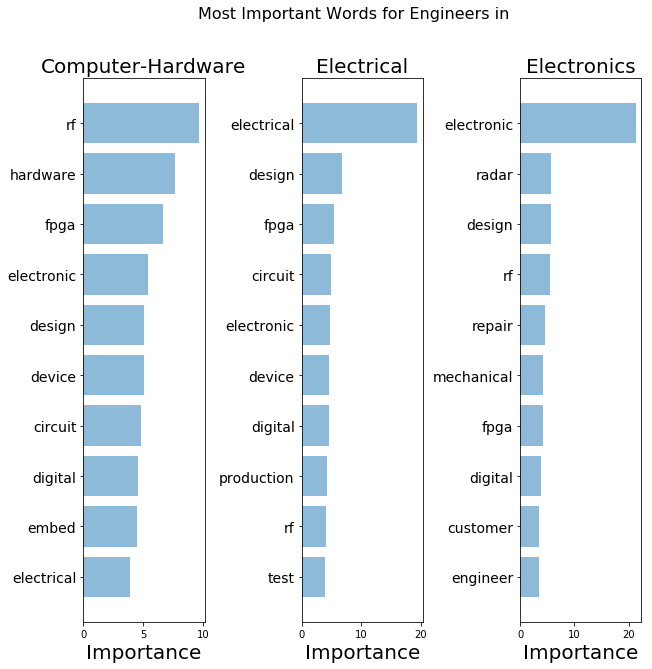

<Figure size 432x288 with 0 Axes>

In [41]:
plot_important_words(importance_LR_100, [4,5,6],'hardware_eletrical_electronics_LR_100')

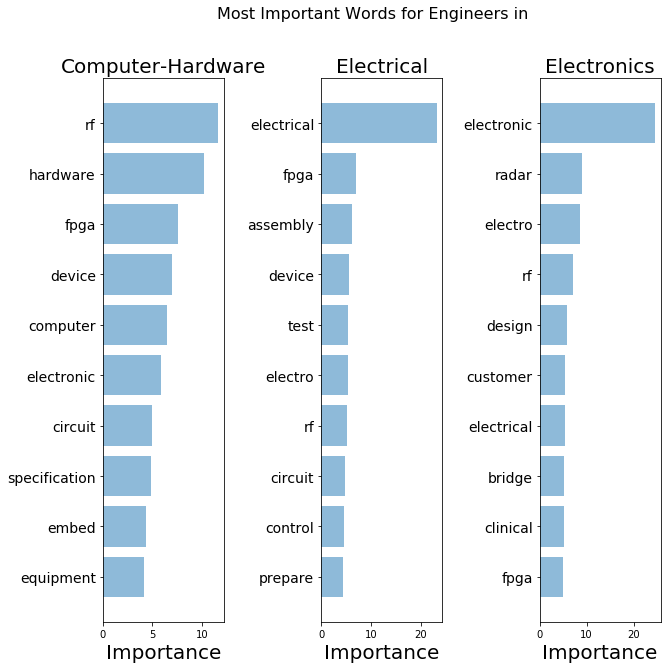

<Figure size 432x288 with 0 Axes>

In [42]:
plot_important_words(importance_LR_200, [4,5,6],'hardware_eletrical_electronics_LR_200')

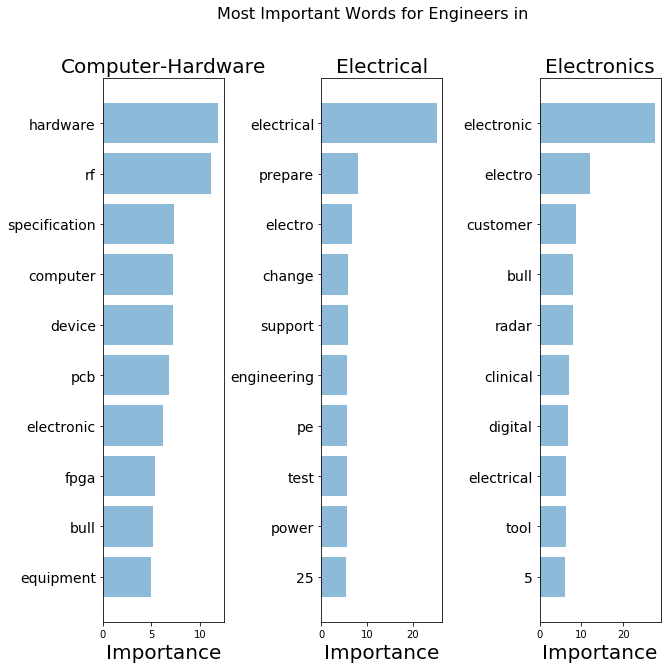

<Figure size 432x288 with 0 Axes>

In [43]:
plot_important_words(importance_LR_400, [4,5,6],'hardware_eletrical_electronics_LR_400')

As shown above, although the accuary of the logsitic regression model improves by change n_components, 

    n_components        train_accuracy            test_accuracy
    100                      0.762                0.740
    200                      0.821                0.791
    400                      0.878                0.842
    
The captured important features for each category varies. As the hyperparameter n_components increases to 400, the model captures some noise, such as "25", "5", "bull", and other general terms "change", "suport", "customer", "tool". 

Therefore, the logistic regression model with n_components = 200 is used for the final classification model.

## 1.3 Final Classification Model

In [16]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import re
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


nlp = spacy.load("en")
#def tokenize_lemma(text):
#    return re.findall(r'\w+', ' '.join([w.lemma_ for w in nlp(text)]))

stop_words_lemma = set(w.lemma_ for w in nlp(' '.join(STOP_WORDS)))

tfidf_unigram = TfidfVectorizer(ngram_range = (1,1),#max_features = 1000,
                            stop_words = stop_words_lemma,
                            tokenizer = None)
clf = LogisticRegression(C = 40.0, class_weight='balanced', solver='newton-cg', 
                     multi_class='multinomial', n_jobs=-1, random_state = 42)

LR_pipe = Pipeline([('tfidf', tfidf_unigram),
                    ('LSA',TruncatedSVD(n_components = 200) ),
                    ('clf', clf)
                 ])
LR_pipe.fit(JD,labels)
print('Training accuracy: ', LR_pipe.score(JD,labels))
dill.dump(LR_pipe,open('monster_JD/dill_folder/LR_pipe_1vsall_test.dill','wb'))

import pickle
with open('monster_JD/dill_folder/LR_pipe_1vsall_test.pkl', 'wb') as pickle_file:
    pickle.dump(LR_pipe, pickle_file)

Training accuracy:  0.8133306320907617


In [14]:
import pickle
with open('monster_JD/dill_folder/LR_pipe_1vsall_test.pkl', 'rb') as pipe:
    LR_pipe = pickle.load(pipe)

In [15]:
test_skill = ['mechanical engineering, AutoCAD, structural evaluation']
top_chance = sorted([(value,ind) for ind, value in enumerate(LR_pipe.predict_proba(test_skill)[0])],key = lambda x:x[0], reverse = True)
print('{:.1%} chance of title {} '.format(top_chance[0][0], eng_titles[top_chance[0][1]]+' Engineer'))
print('{:.1%} chance of title {} '.format(top_chance[1][0], eng_titles[top_chance[1][1]]+' Engineer'))

96.7% chance of title Mechanical Engineer 
3.1% chance of title Civil Engineer 


In [20]:
test_skill = ['mechanical engineering, PE license , structural evaluation, AutoCAD']
top_chance = sorted([(value,ind) for ind, value in enumerate(LR_pipe.predict_proba(test_skill)[0])],key = lambda x:x[0], reverse = True)
print('{:.1%} chance of title {} '.format(top_chance[0][0], eng_titles[top_chance[0][1]]+' Engineer'))
print('{:.1%} chance of title {} '.format(top_chance[1][0], eng_titles[top_chance[1][1]]+' Engineer'))

72.5% chance of title Civil Engineer 
27.4% chance of title Mechanical Engineer 


# Part 2 Predict Job Openings

This part uses Bureau of Labor Statistics data to predict the job openings for specific occupation titles in a year. Three datasets are used: 
         
         Occupation employment OE

         Current employees at state/area level monthly SM
         
         Business Dynamics report empolyeement openings time series at different industry nationwide quarterly BD
         

   ## 1. Business Employment Dynamics (BD) Dataset
Govenment dataset BD (Business Employment Dynamics) statistics track changes in employment at the establishment level, revealing the dynamics underlying net changes in employment.

There are four types of job flows: employment gains at opening establishments, employment expansions at existing establishments, employment losses at closing establishments,and employment contractions at existing establishments.  Increases in employment at opening and expanding establishments sum to measure job gains.  Declines in employment at closing and contracting establishments sum to measure job losses.The more traditional measures of a net change in the employment is the difference between the number of jobs gains and the number of jobs lost.

Business Employment Dynamics are updated quarterly. Reference quarters end in March, June, September, and December.

Dataset source: https://download.bls.gov/pub/time.series/bd/



In [23]:
# import BD dataset and maping file
path = root + '/Govenment_data/BD_business_employment_dynamics/'
filename = path + 'bd.data.1.AllItems.txt'
BD = pd.read_csv(filename,header = 0,sep = '\t',quotechar = '"',low_memory=False)
BD['date'] = BD.year.apply(str) + BD.period
BD['seasonal'] = BD.series_id.str[2]
BD['msa_code'] = BD.series_id.str[3:8]
BD['state_code'] = BD.series_id.str[8:10]
BD['county_code'] = BD.series_id.str[10:13]
BD['industry_code'] = BD.series_id.str[13:19]
BD['unitanalysis_code'] = BD.series_id.str[19]
BD['dataelement_code'] = BD.series_id.str[20]
BD['sizeclass_code'] = BD.series_id.str[21:23]
BD['dataclass_code'] = BD.series_id.str[23:25]
BD['ratelevel_code'] = BD.series_id.str[25]
BD['periodicity_code'] = BD.series_id.str[26]
BD['ownership_code'] = BD.series_id.str[27]
print(BD.shape)
BD.head()

(3599376, 18)


,series_id,year,period,value,footnote_codes,date,seasonal,msa_code,state_code,county_code,industry_code,unitanalysis_code,dataelement_code,sizeclass_code,dataclass_code,ratelevel_code,periodicity_code,ownership_code
0,BDS0000000000000000110001LQ5,1992,Q03,7369,1,1992Q03,S,00000,00,000,000000,1,1,00,01,L,Q,5
1,BDS0000000000000000110001LQ5,1992,Q04,6940,1,1992Q04,S,00000,00,000,000000,1,1,00,01,L,Q,5
2,BDS0000000000000000110001LQ5,1993,Q01,7280,1,1993Q01,S,00000,00,000,000000,1,1,00,01,L,Q,5
3,BDS0000000000000000110001LQ5,1993,Q02,7215,1,1993Q02,S,00000,00,000,000000,1,1,00,01,L,Q,5
4,BDS0000000000000000110001LQ5,1993,Q03,7585,1,1993Q03,S,00000,00,000,000000,1,1,00,01,L,Q,5


### 1.1 Industry mapping file for BD dataset

In [24]:
# industry mapping file
path = root + '/Govenment_data/BD_business_employment_dynamics/'
filename = path + 'bd.industry.txt'
bd_industry = pd.read_csv(filename,header = 0, dtype=str,sep = '\t',quotechar = '"')
bd_ind = bd_industry[bd_industry.industry_code.str.contains('300')]
temp = bd_industry[bd_industry.industry_code =='000000']
temp2 = bd_industry[bd_industry.industry_code =='200040']
#print(type(temp),type(bd_ind))
bd_ind = pd.concat([temp,temp2,bd_ind])
bd_ind['ind_code']= bd_ind.industry_code.str[3:]
bd_ind.loc[0,'ind_code'] ='001'
bd_ind.loc[9,'ind_code'] ='221'
bd_ind = bd_ind.drop(['display_level','selectable', 'sort_sequence'],axis=1)
bd_ind = bd_ind.rename(index = str, columns = {'industry_code':'bd_industry', 'industry_name':'bd_industry_name'})
print(bd_ind.shape)
bd_ind.head()

(88, 3)


,bd_industry,bd_industry_name,ind_code
0,000000,Total private,001
9,200040,Utilities,221
16,300111,Crop production,111
17,300112,Animal production,112
18,300113,Forestry and logging,113


### 1.2 State Mapping file for BD dataset

In [25]:
# load state mapping file
filename = path + 'bd.state.txt'
bd_state= pd.read_csv(filename,header = 0,dtype=str,sep = '\t',quotechar = '"')
print(bd_state.shape)
bd_state.loc[0]['state_name'] = 'National'
bd_state.head()
# BD has national + 53 states (including Puerto Rico (72) and Virgin Islands (78))

(54, 2)


,state_code,state_name
0,00,National
1,01,Alabama
2,02,Alaska
3,04,Arizona
4,05,Arkansas


## 2.0 Occupation Employment (OE) Dataset


The Occupational Employment Statistics (OES) program conducts a semi-annual mail survey designed to produce estimates of employment and wages for specific occupations. The OES program collects data on wage and salary workers in nonfarm establishments in order to produce employment and wage estimates for about 800 occupations. The OES program produces these occupational estimates by geographic area and by industry. Estimates based on geographic areas are available at the National, State, Metropolitan, and Nonmetropolitan Area levels. The Bureau of Labor Statistics produces occupational employment and wage estimates for over 450 industry classifications at the national level. 

Summary Data Available:  Cross-industry estimates are available by Nation, State, and metropolitan area for about 800 occupations.  Industry specific estimates are available at the National level for over 450 industries.  

Employment estimates are rounded to the nearest ten and are stored with no decimal place.


Updating Schedule:  The OES estimates are updated annually, normally in May. Right now there is only one record in 2017 is available for this study.

Dataset Source: https://download.bls.gov/pub/time.series/oe/

In [26]:
# load Occupation Employment dataset
path = root +'/Govenment_data/OE_occupation_employment/'
filename = path + 'oe.data.0.Current.txt'
OE = pd.read_csv(filename,header = 0,sep = '\t',quotechar = '"')
OE['seasonal'] = OE.series_id.str[2]
OE['areatype_code'] = OE.series_id.str[3]
OE['area_code'] = OE.series_id.str[4:11]
OE['industry_code'] = OE.series_id.str[11:17]
OE['occupation_code'] = OE.series_id.str[17:23]
OE['datatype_code'] = OE.series_id.str[23:25]
print(OE.shape)
OE.head()

(6253097, 11)


,series_id,year,period,value,footnote_codes,seasonal,areatype_code,area_code,industry_code,occupation_code,datatype_code
0,OEUM001018000000000000001,2017,A01,64450,,U,M,0010180,000000,000000,01
1,OEUM001018000000000000002,2017,A01,2.3,,U,M,0010180,000000,000000,02
2,OEUM001018000000000000003,2017,A01,19.88,,U,M,0010180,000000,000000,03
3,OEUM001018000000000000004,2017,A01,41350,,U,M,0010180,000000,000000,04
4,OEUM001018000000000000005,2017,A01,2.2,,U,M,0010180,000000,000000,05


### 2.1 Industry Mapping file for OE dataset

In [27]:
# load oe industry mapping file
path = root +'/Govenment_data/OE_occupation_employment/'
filename = path + 'oe.industry.txt'
names =['industry_code', 'industry_name', 'display_level','selectable', 'sort_sequence']
oe_industry = pd.read_csv(filename,header = None, names = names,dtype= str, sep = '\t',quotechar = '"')
oe_industry.head()
oe_ind = oe_industry[oe_industry.industry_code.str.contains('000')] # industry level 3, only available at national level
print(oe_ind.shape)
oe_ind['ind_code'] = oe_ind.industry_code.str[:3]
oe_ind.ind_code[2] = '001'
oe_ind = oe_ind.drop(['display_level','selectable', 'sort_sequence'],axis=1)
oe_ind = oe_ind.rename(index= str, columns ={'industry_code':'oe_industry', 'industry_name':'oe_industry_name'})
oe_ind.head()

(90, 5)


/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/data3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,oe_industry,oe_industry_name,ind_code
1,000000,"Cross-industry, Private, Federal, State, and L...",000
2,000001,"Cross-industry, Private Ownership Only",001
4,113000,Forestry and Logging,113
6,115000,Support Activities for Agriculture and Forestry,115
10,211000,Oil and Gas Extraction,211


The industry code used in Business Dynamics (BD) dataset is different from the one used in occupation matrix. Build up the proper mapping between those two dataset for analysis 

In [28]:
# find the connection between two dataset at industry level
ind_match2 = pd.merge(oe_ind,bd_ind, how = 'inner',on='ind_code')

print(ind_match2.shape)
ind_match2.head()
# note that industry level 300 only has data at national level, not in state level
# no corresponding data in BD for 482000 - rail transportation
#                                491000 - post service
#                                521000 - monetary bank
# utility 300221 is corresponding to 200040

(85, 5)


,oe_industry,oe_industry_name,ind_code,bd_industry,bd_industry_name
0,000001,"Cross-industry, Private Ownership Only",001,000000,Total private
1,113000,Forestry and Logging,113,300113,Forestry and logging
2,115000,Support Activities for Agriculture and Forestry,115,300115,Support activities for agriculture and forestry
3,211000,Oil and Gas Extraction,211,300211,Oil and gas extraction
4,212000,Mining (except Oil and Gas),212,300212,Mining (except oil and gas)


### 2.2 State Mapping file for OE dataset

In [29]:
# load state mapping file
filename = path + 'oe.area.txt'
names =['state_code', 'area_code', 'areatype_code','area_name']
oe_area= pd.read_csv(filename,header = None, names = names,dtype = str,sep = '\t',quotechar = '"')
print(oe_area.shape)
oe_state = oe_area[oe_area.areatype_code!='M']
oe_state = oe_state.drop(index=0)
print(oe_state.shape)
oe_state.head()
# OE has national + 54 states (including Guam (66), Puerto Rico (72) and Virgin Islands (78)) 

(656, 4)
(55, 4)


,state_code,area_code,areatype_code,area_name
1,00,0000000,N,National
14,01,0100000,S,Alabama
21,02,0200000,S,Alaska
31,04,0400000,S,Arizona
39,05,0500000,S,Arkansas


### 2.3 Occupation Mapping file for OE dataset

There are total of 1072 different occupation titles. 

In [30]:
filename = path + 'oe.occupation.txt'
names =['occupation_code', 'occupation_name', 'display_level','selectable', 'sort_sequence']
oe_occupation = pd.read_csv(filename,header = None, names = names,dtype= str,sep = '\t',quotechar = '"')
oe_occupation = oe_occupation.drop(index=0)
print(oe_occupation.shape)
oe_occupation.head()

(1072, 5)


,occupation_code,occupation_name,display_level,selectable,sort_sequence
1,000000,All Occupations,0,T,0
2,110000,Management Occupations,0,T,1
3,111000,Top Executives,1,T,2
4,111011,Chief Executives,3,T,3
5,111021,General and Operations Managers,3,T,4


# 3.0 State and Area Employment, hours, and earnings  (SM) Dataset

The State and area Current Employment Dataset recorded all employment, hours, and earnings series classified according to the 2012 North American Industrial Classification System (NAICS). All data are monthly.



In [31]:
# import SM state level data
# note that the employment are measured in thousands of workers, need to multiply 1000 to get the correct answer
path = root + '/Govenment_data/SM_state_area_employment/'
filename = path + 'sm.data.0.Current.txt'
SM = pd.read_csv(filename,header = 0,sep = '\t',quotechar = '"',low_memory=False)
SM['seasonal'] = SM.series_id.str[2]
SM['state_code'] = SM.series_id.str[3:5]
SM['area_code'] = SM.series_id.str[5:10]
SM['supersector_code'] = SM.series_id.str[10:12]
SM['industry_code'] = SM.series_id.str[10:18]
SM['data_type_code'] = SM.series_id.str[18:20]
SM.head(3)

,series_id,year,period,value,footnote_codes,seasonal,state_code,area_code,supersector_code,industry_code,data_type_code
0,SMS01000000000000001,2006,M01,1985.2,,S,01,00000,00,00000000,01
1,SMS01000000000000001,2006,M02,1988.7,,S,01,00000,00,00000000,01
2,SMS01000000000000001,2006,M03,1994.5,,S,01,00000,00,00000000,01


In [32]:
SM.shape

(3929004, 11)

In [33]:
SM_em = SM[SM.data_type_code=='01'][SM.area_code=='00000']
SM_em = SM_em[SM_em.year ==2018][SM_em.period =='M12']
SM_em = SM_em[SM_em.seasonal == 'U']
# from 2007.1 to 2018.12, 12 month + M13 for yearly average
# only at big industry level, 300000, at state and metro area

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### 3.1 Industry Mapping File for SM dataset

In [34]:
# import sm industry_code mapping file
path = root + '/Govenment_data/SM_state_area_employment/'
filename = path + 'sm.industry.txt'
sm_industry = pd.read_csv(filename,header = 0,sep = '\t',dtype = str, quotechar = '"',low_memory=False)
sm_industry = sm_industry[sm_industry.industry_code.apply(int)%1000 ==0]
sm_industry['ind_code'] = sm_industry.industry_code.str[2:5]
sm_ind = sm_industry[sm_industry.ind_code !='000']
temp = sm_industry[sm_industry.industry_code=='05000000']
sm_ind = pd.concat([temp,sm_ind])
print(sm_ind.shape)
sm_ind.head()


(93, 3)


,industry_code,industry_name,ind_code
1,05000000,Total Private,000
7,10210000,"Mining, Quarrying, and Oil and Gas Extraction",210
8,10211000,Oil and Gas Extraction,211
9,10212000,Mining (except Oil and Gas),212
12,10213000,Support Activities for Mining,213


In [35]:
# deal with mismatching: 
# 10113300 -> 113  already filter out
# 43220000 -> 221
# 55522000 -> 521
# 60530000 -> 531
# 60540000 -> 541
# 60550000 -> 551
# 60560000 -> 561
# 65610000 -> 611
sm_ind.loc[1,'ind_code'] = '001'
sm_ind.loc[159,'ind_code'] = '221'
sm_ind.loc[215,'ind_code'] = '531'
sm_ind.loc[226,'ind_code'] = '541'
sm_ind.loc[236,'ind_code'] = '551'
sm_ind.loc[237,'ind_code'] = '561'
sm_ind.loc[252,'ind_code'] = '611'
sm_ind = sm_ind.rename(index = str, columns ={'industry_code':'sm_industry', 'industry_name':'sm_industry_name'})

sm_ind.head()

,sm_industry,sm_industry_name,ind_code
1,05000000,Total Private,001
7,10210000,"Mining, Quarrying, and Oil and Gas Extraction",210
8,10211000,Oil and Gas Extraction,211
9,10212000,Mining (except Oil and Gas),212
12,10213000,Support Activities for Mining,213


#### build industry mapping dictionary for three datasets

In [36]:
ind_match = pd.merge(ind_match2,sm_ind,how = 'inner',on = 'ind_code')
print(ind_match.shape)
ind_match.head()
# find any NA values in the matching file in the row
#ind_match[ind_match.isnull().any(axis=1)]

(81, 7)


,oe_industry,oe_industry_name,ind_code,bd_industry,bd_industry_name,sm_industry,sm_industry_name
0,000001,"Cross-industry, Private Ownership Only",001,000000,Total private,05000000,Total Private
1,211000,Oil and Gas Extraction,211,300211,Oil and gas extraction,10211000,Oil and Gas Extraction
2,212000,Mining (except Oil and Gas),212,300212,Mining (except oil and gas),10212000,Mining (except Oil and Gas)
3,213000,Support Activities for Mining,213,300213,Support activities for mining,10213000,Support Activities for Mining
4,221000,Utilities,221,200040,Utilities,43220000,Utilities


In [37]:
print(SM_em.shape)
sm_matrix = SM_em[SM_em.industry_code.isin(ind_match.sm_industry.values)]
print(sm_matrix.shape)
sm_matrix = sm_matrix.set_index(['state_code','industry_code']).value
sm_in = sm_matrix.unstack('state_code')
sm_in = sm_in.fillna(0)
sm_in['00'] = sm_in.sum(axis=1,skipna = True)
sm_in.head()

(4447, 11)
(1840, 11)


state_code,01,02,04,05,06,08,09,10,11,12,...,49,50,51,53,54,55,56,72,78,00
industry_code,,,,,,,,,,,,,,,,,,,,,
05000000,1680.3,230.7,2503.4,1045.8,14795.2,2326.9,1489.0,400.2,562.3,7868.3,...,1293.6,260.3,3340.1,2878.2,603.7,2586.3,218.4,664.7,27.0,128831.7
10211000,0.0,0.0,0.0,0.0,5.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.1,0.0,0.0,92.2
10212000,5.0,0.0,0.0,0.0,5.7,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,8.8,0.0,0.0,27.3
10213000,0.0,6.8,0.0,0.0,9.9,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.3,0.0,0.0,255.9
20236000,20.1,0.0,36.1,0.0,188.5,32.2,10.7,5.0,0.0,115.2,...,21.6,0.0,43.1,57.4,0.0,28.6,4.2,10.4,0.0,1578.5



### 3.2 Create table for number of employment for each occupation in each state as a baseline for job opening prediction



In [38]:

ems = OE[OE.areatype_code =='S']  # at state level
ems = ems[ems.datatype_code == '01']  # 01- employment
ems_occup = ems.set_index(['area_code','occupation_code']).value
ems_matrix = ems_occup.unstack('area_code')

ems_matrix = ems_matrix.applymap(lambda x: np.nan if x == '           -' else x)  
# replace '-' with NaN
print(ems_matrix.shape)
ems_matrix = ems_matrix.fillna(0)
ems_matrix = ems_matrix.applymap(float)
ems_matrix.head()

(831, 54)


area_code,0100000,0200000,0400000,0500000,0600000,0800000,0900000,1000000,1100000,1200000,...,4900000,5000000,5100000,5300000,5400000,5500000,5600000,6600000,7200000,7800000
occupation_code,,,,,,,,,,,,,,,,,,,,,
000000,1922570.0,318170.0,2704050.0,1200130.0,16695010.0,2555300.0,1654420.0,442690.0,708220.0,8419030.0,...,1410670.0,305110.0,3789910.0,3186610.0,688530.0,2825170.0,267980.0,61520.0,875780.0,37490.0
110000,69950.0,18420.0,167980.0,61040.0,942620.0,112920.0,117120.0,18250.0,86030.0,341050.0,...,92960.0,13870.0,168390.0,161960.0,30110.0,129080.0,11690.0,5170.0,38230.0,3420.0
111011,1120.0,680.0,7170.0,2140.0,30430.0,640.0,1450.0,320.0,2140.0,19350.0,...,4340.0,410.0,6080.0,5390.0,990.0,5160.0,140.0,420.0,2550.0,130.0
111021,27150.0,6580.0,50370.0,20630.0,255210.0,41560.0,31660.0,4010.0,26210.0,97630.0,...,39810.0,3030.0,51370.0,46740.0,10560.0,32590.0,4910.0,1610.0,5850.0,1710.0
111031,1100.0,110.0,600.0,1010.0,2970.0,640.0,380.0,140.0,0.0,1410.0,...,690.0,0.0,570.0,970.0,0.0,930.0,70.0,0.0,0.0,0.0


### 3.3 Create tables for employment of all occupations

In [39]:
oe_em = OE[OE.areatype_code =='N']  # at national level
oe_em = oe_em[oe_em.datatype_code =='01'] # 01 - employment
oe_em = oe_em[oe_em.industry_code.isin(np.append(ind_match.oe_industry.values, '000001'))]  # lower level industry, available at national level
em_occup = oe_em.set_index(['industry_code','occupation_code']).value
oe_matrix = em_occup.unstack('industry_code')
oe_matrix.head()

oe_eng = oe_matrix.applymap(lambda x: np.nan if x == '           -' else x) # replace '-' with NaN
print(oe_eng.shape)
oe_eng = oe_eng.fillna(0)
oe_eng = oe_eng.applymap(float)
oe_eng.head()

(1060, 79)


industry_code,000001,211000,212000,213000,221000,236000,237000,238000,311000,312000,...,623000,624000,711000,712000,713000,721000,722000,811000,812000,813000
occupation_code,,,,,,,,,,,,,,,,,,,,,
000000,120851270.0,135480.0,182720.0,272930.0,552270.0,1519970.0,997060.0,4386080.0,1565530.0,256460.0,...,3324640.0,3684360.0,488440.0,161560.0,1720160.0,2026360.0,11591330.0,1303690.0,1466290.0,1371930.0
110000,6224740.0,13300.0,7150.0,13400.0,39420.0,174170.0,65140.0,195990.0,52270.0,12750.0,...,103160.0,173150.0,26540.0,12320.0,53990.0,87220.0,256150.0,45500.0,35220.0,137690.0
111000,2245770.0,4720.0,4000.0,8020.0,13460.0,45810.0,21810.0,100010.0,19280.0,5270.0,...,27200.0,42340.0,14300.0,5690.0,33200.0,19020.0,85650.0,37150.0,21280.0,61530.0
111011,173260.0,250.0,130.0,450.0,1070.0,3330.0,1660.0,4660.0,1620.0,410.0,...,2830.0,4920.0,1670.0,800.0,1110.0,790.0,1760.0,710.0,770.0,7090.0
111021,2072500.0,4470.0,3870.0,7570.0,12380.0,42480.0,20150.0,95360.0,17660.0,4860.0,...,24380.0,37420.0,12630.0,4890.0,32090.0,18230.0,83900.0,36440.0,20520.0,54440.0


The above employment matrix describes the employment in different industry for each occupation at national level. For example, the total empolyment in industry category 211000 (oil and gas extraction) is 135480, while the management occupation (with code 110000) in this industry is 13300.  

In [47]:
def plot_occupation_dist(occup_id, title1):
    occup = oe_eng.loc[occup_id]
    indus = occup.index
    value = occup.values


    ls = [(ind,val) for ind,val in zip(indus,value)]
    ls = sorted(ls,key = lambda x: x[1], reverse= True)
    new_indus = [ind_match[ind_match.oe_industry ==ind].oe_industry_name.values[0] for (ind,val) in ls[1:12]]
    new_value = [val for (ind,val) in ls[1:12]]
    total = ls[0][1]

    fig, ax = plt.subplots(figsize=(8, 6))
    y_pos = np.arange(len(new_value))


    plt.barh(y_pos,new_value[::-1]/total, align='center', alpha=0.5)
    vals = ax.get_xticks()
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals])
    plt.title(title1 + " Occupation", fontsize=20)


    plt.yticks(y_pos, new_indus[::-1], fontsize=14)
    plt.tick_params(axis="y",direction="in", pad=-440,labelleft="on")
    plt.xlabel('Employment Percentage', fontsize=20)
    plt.show()


/opt/conda/envs/data3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


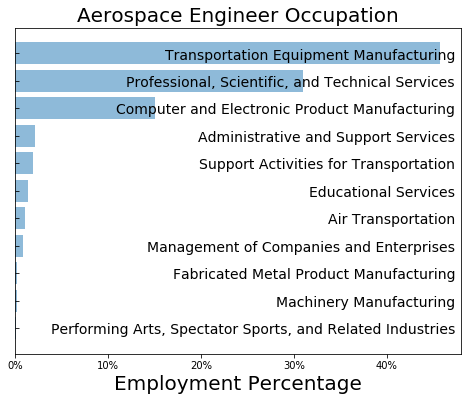

In [48]:
plot_occupation_dist('172011', "Aerospace Engineer")

# 4.0 Build ML Model to Predict Job Openings

As the job openings time series data (BD) is only available at national level for each industry. The prediction of the job openings for each occupation is seperated into two steps:

     1. Predict job openings for each industry for next year ( National level)
     2. Map the job openings to each occupation ( State level)

## 4.1 Predict Job Opening for Each Industry

First step is to predict employment openings at different industry next year Nationwide using time series data in BD dataset.  


Below is the BD dataset for training

In [49]:
# function to transfer date string to datestamps for time series
def assign_date(string):
   # if stype = 'min':        
    if string =='Q01': 
        return '-03-31'
    if string =='Q02':
        return '-06-30'
    if string =='Q03':
        return '-09-30'
    if string =='Q04':
        return '-12-31'
    
mindate = min(BD[BD.state_code =='11'].date)
start_date = mindate[:4]+assign_date(mindate[4:])


In [50]:
bd_em = BD[BD.state_code == '00']   # choose national data
bd_em = bd_em[bd_em.series_id.str.contains('BDS00000')]
bd_em = bd_em[bd_em.series_id.str.contains('110001LQ5  ')]
print(bd_em.shape)
bd_em = bd_em[bd_em.industry_code.isin(ind_match.bd_industry.values)]
print(bd_em.shape)
bd_matrix = bd_em.set_index(['industry_code','date']).value
bd_matrix = bd_matrix.unstack('industry_code')
bd_matrix = bd_matrix.applymap(int)
mindate = min(bd_em.date)
start_date = mindate[:4]+assign_date(mindate[4:])
dti = pd.date_range(start_date, periods = bd_matrix.shape[0], freq = 'Q')

(10506, 18)
(8137, 18)


In [51]:
bd_matrix.head(2)

industry_code,000000,200040,300211,300212,300213,300236,300237,300238,300311,300312,...,300623,300624,300711,300712,300713,300721,300722,300811,300812,300813
date,,,,,,,,,,,,,,,,,,,,,
1992Q03,7369,14,7848,17844,16441,191055,117727,436921,109569,12914,...,104162,115722,69650,9433,181846,141287,693363,92631,96625,101611
1992Q04,6940,11,11136,14330,18515,183049,117531,427928,105263,12476,...,95490,112080,70166,6893,147346,131475,686374,96112,95416,94248


### 4.4.1 Machine Learning Model 

### Time Series Model

The data is a times series trend, How about a time series model? 

First need to check trend and seasonality of the time series signal

In [52]:
from scipy import fftpack

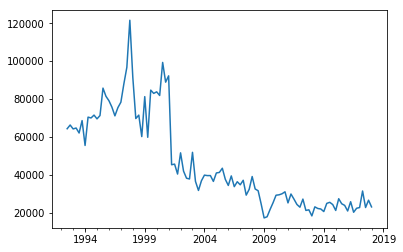

In [30]:
ind_code = '300334'  # Computer and electronic product manufacturing
y = bd_matrix[ind_code].values
df = pd.Series(y, index = dti[:len(y)])
df.plot()

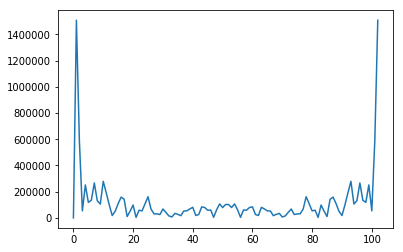

In [31]:
df= df.to_frame(name='Value')
fft = fftpack.fft(df.Value-df.Value.mean())
plt.plot(np.abs(fft))

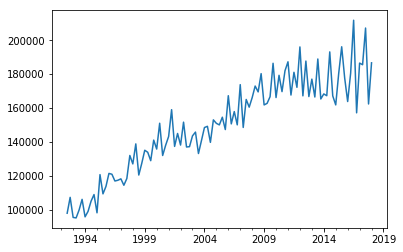

In [32]:
ind_code = '300611'  # educational service
y = bd_matrix[ind_code].values
df = pd.Series(y, index = dti[:len(y)])
df.plot()

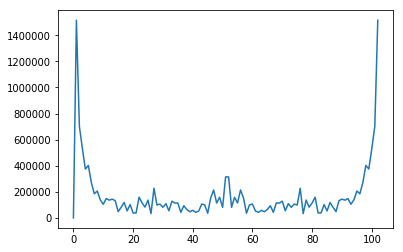

In [33]:
df= df.to_frame(name='Value')
fft = fftpack.fft(df.Value-df.Value.mean())
plt.plot(np.abs(fft))

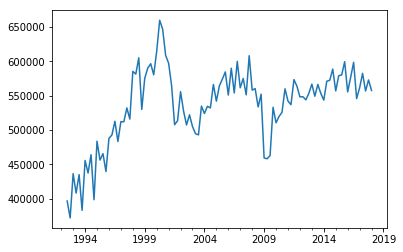

In [34]:
ind_code = '300541'  # professional service
y = bd_matrix[ind_code].values
df = pd.Series(y, index = dti[:len(y)])
df.plot()

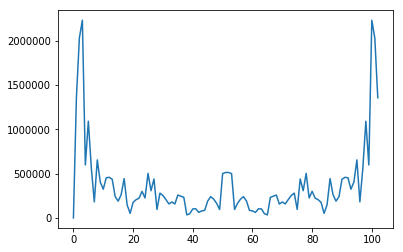

In [35]:
df= df.to_frame(name='Value')
fft = fftpack.fft(df.Value-df.Value.mean())
plt.plot(np.abs(fft))

As shown in the three groups of industry data plots above, there is a decrease trend in computer manufacturing while a increase trend in the educational service. There is no clear seasonality shown in the data. So we only need to remove the trend before applying TS model.

The TS model is as follows:

In [53]:
forcast = 7
dti = pd.date_range(start_date, periods = bd_matrix.shape[0]+forcast, freq = 'Q')

In [54]:
from sklearn.linear_model import Ridge
from statsmodels.tsa.ar_model import AR
import sklearn.metrics
import math

def TS_pred(y1,forcast=7, plotopt = 0, title =''):
    X = [[float(i)]+[1.0] for i in range(len(y1))] 
    maxy = max(y1)
    y = [math.log(item/maxy) for item in y1]
    exp_model = Ridge().fit(X,y)
    X1 = [[float(i)]+[1.0] for i in range(len(y)+forcast)]
    y_pred_exp = exp_model.predict(X1)  
    
    # predict next
    residual = y - y_pred_exp[:len(y)]

    # use Time series AR model to training the residual signal after remove the trend
    df = pd.Series(residual, index = dti[:len(y)])
    AR_model = AR(df)
    model_fit = AR_model.fit()
    Lag = model_fit.k_ar 
    y_pred_ts = model_fit.predict(start = Lag,end = len(df) + forcast-1,dynamic = False)  
    
    # final prediction is the exponential of sum of two model predictions 
    pred = y_pred_exp[Lag:] + y_pred_ts
    pred = [int(math.exp(item)*maxy) for item in pred]
    
    # calculate R2 and plot
    if plotopt ==1:
        fig = plt.figure(figsize=(10, 6))
        sse,sst = 0,0
        ymean = sum(y1[Lag:])/len(y1[Lag:])
        for i in range(len(y)-Lag):
            sse += (y1[Lag+i] - pred[i])**2
            sst += (y1[Lag+i] - ymean)**2
        R2 = 1-sse/sst
        print('R2 score of prediction: ', R2)
        
        plt.plot(dti[Lag:len(y1)],y1[Lag:], label = 'BD data')
        plt.plot(dti[Lag:],pred,'r--', label = 'Prediction')
        plt.legend(fontsize ='large')
        plt.title('Job Opening Prediction for ' + title)
    
    return pred[-forcast:]

R2 score of prediction:  0.891593938166626


[25697, 20260, 21186, 18917, 21177, 17714, 19413]

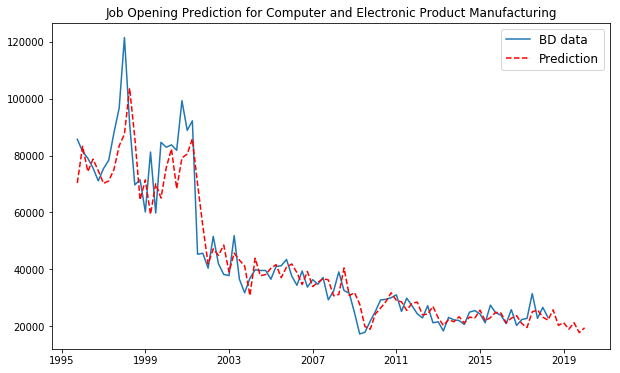

In [55]:
ind_code = '300334'  # Computer and electronic product manufacturing 
y = bd_matrix[ind_code].values
TS_pred(y,7, 1, 'Computer and Electronic Product Manufacturing')

R2 score of prediction:  0.8804396564739718


[194851, 204626, 176693, 193617, 206758, 204022, 189547]

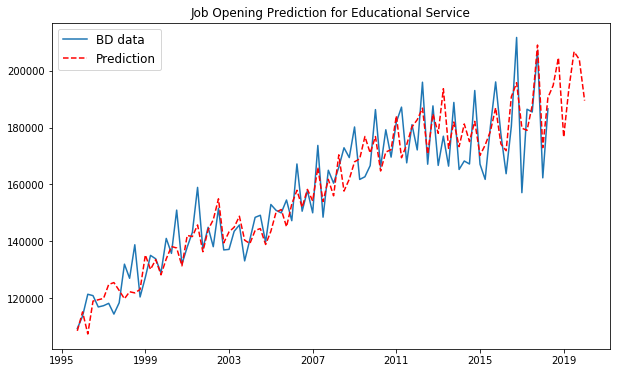

In [56]:
ind_code = '300611'  # educational service
y = bd_matrix[ind_code].values
TS_pred(y,7, 1, 'Educational Service')

R2 score of prediction:  0.6835131180422884


[576778, 572213, 578125, 577004, 595443, 591958, 597707]

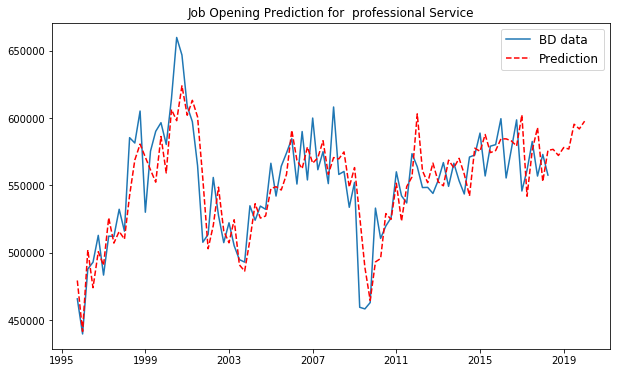

In [57]:
ind_code = '300541'  # professional service
y = bd_matrix[ind_code].values
TS_pred(y,7, 1,' professional Service')

As shown above, the time series model shows lower R2 score compared to the simple regression model.

Therefore, in this model, simple regression model is used for the job opening prediction

In [58]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import dill

def predict_national_employ_ts(forcast):
    bd_em = BD[BD.state_code == '00']   # choose national data
    bd_em = bd_em[bd_em.series_id.str.contains('BDS00000')]
    bd_em = bd_em[bd_em.series_id.str.contains('110001LQ5  ')]
    print(bd_em.shape)
    bd_em = bd_em[bd_em.industry_code.isin(ind_match.bd_industry.values)]
    print(bd_em.shape)
    bd_matrix = bd_em.set_index(['industry_code','date']).value
    bd_matrix = bd_matrix.unstack('industry_code')
    bd_matrix = bd_matrix.applymap(int)
    mindate = min(bd_em.date)
    start_date = mindate[:4]+assign_date(mindate[4:])
    dti = pd.date_range(start_date, periods = bd_matrix.shape[0]+forcast, freq = 'Q')


    count=0
    for ind_code in bd_matrix.columns.values:
        if ind_code != '000000':
            count += 1
            y = bd_matrix[ind_code].values
            
            pred = TS_pred(y,forcast)
            prediction = pd.Series(pred, index = dti[-forcast:])
            if count == 1:
                pred1 = prediction.rename(ind_code)
            else:
                pred1 =pd.concat([pred1, prediction.rename(ind_code)], axis=1)
            
    # save prediction to dill, each state get one model
    dill.dump(pred1, open('pred_national_ts.dill','wb')) 

In [59]:
# now predict the openings at nation level at each industry category
forcast=7
predict_national_employ_ts(forcast)

(10506, 18)
(8137, 18)


In [60]:
pred = dill.load(open('pred_national_ts.dill','rb'))
pred.head(2)

,200040,300211,300212,300213,300236,300237,300238,300311,300312,300313,...,300623,300624,300711,300712,300713,300721,300722,300811,300812,300813
2018-06-30,11,6241,9006,30964,157083,108783,428368,66172,16691,3369,...,114827,263853,88525,10673,218568,123515,881049,89621,106927,104452
2018-09-30,11,6457,8710,29723,159290,102456,417939,61787,15433,3205,...,114056,260975,88438,10389,183412,115378,896138,88801,103727,102558


## 4.2 Predict Job Opening for each Occupation at State Level


The openings for specific occupation, such as aerospace engineering at each state is calculated as below:

         current AE employment in state j * estimated opening rate for AE occupation at state j
         
As 30% of AE occupation comes from manufacture, 30% comes from professional service, The opening rate for AE occupation is calculated as:

        sum( opening rate at industry i * percent of AE occupation in industry i )
        
However, each industry has diffferent weight in each state, for state with higher employment increase rate in manufacturing industry, the opening rate in manufacturing industry should be weighted more. Therefore, the weighted factor for each state and each industry is calculated as

       weight_factor for industry i = average employment monthly change rate in industry i at state j in last year *1000


At the end, as weight factor included, the final prediction on openings at each occupation need to be normalized such that the sum up opening is equal to total occupation employee * nationwide average opening rate
        




### 4.2.1 Validate the total employment at each industry using two datasets

In [61]:
pred = dill.load(open('pred_national_ts.dill', 'rb'))
occup_code ='172011'
total_occup_nation = 0
occup_em = 0
for ind_code in pred.columns.values:
    sm_industry = ind_match[ind_match.bd_industry == ind_code].sm_industry.values[0]
    oe_industry = ind_match[ind_match.bd_industry == ind_code].oe_industry.values[0]

    # percent of occupation from industry i
    percent = oe_eng.loc[occup_code][oe_industry]/oe_eng.loc[occup_code]['000001']

    # ratio of occupation in all occupations in industry i
    ratio = oe_eng.loc[occup_code][oe_industry]/oe_eng.loc['000000'][oe_industry]

    # total occupation nationwide  = sum (opening in industry i * ratio )
    total_occup_nation += pred[ind_code] * ratio 
    openingrate = pred[ind_code]/(sm_in.loc[sm_industry]['00']*1000)
    occup_em +=(sm_in.loc[sm_industry]['00']*1000)*ratio 

    if percent >0:
        print('industry {}, opening {:10.0f}, rate {:1.4f}, ratio {:1.4f} percent {:1.4f}'.format(ind_code , pred.loc['2019-12-31'][ind_code], openingrate.loc['2019-12-31'],ratio,percent))
        
print('total national occup opening {:10.0f}'.format( total_occup_nation.loc['2019-12-31']))
print('opening rate {:1.4f}'.format( total_occup_nation.loc['2019-12-31']/oe_eng.loc[occup_code]['000001']))
print('employ by cal: {:10.0f}, employ on file {}'.format(occup_em, oe_eng.loc[occup_code]['000001'] ))

industry 300332, opening      47767, rate 0.0366, ratio 0.0001 percent 0.0018
industry 300333, opening      27345, rate 0.0296, ratio 0.0001 percent 0.0018
industry 300334, opening      19413, rate 0.0196, ratio 0.0081 percent 0.1507
industry 300336, opening      37483, rate 0.0238, ratio 0.0158 percent 0.4572
industry 300481, opening      10360, rate 0.0232, ratio 0.0013 percent 0.0109
industry 300488, opening      38262, rate 0.0912, ratio 0.0016 percent 0.0198
industry 300541, opening     597707, rate 0.0639, ratio 0.0020 percent 0.3092
industry 300551, opening      70592, rate 0.0303, ratio 0.0002 percent 0.0089
industry 300561, opening     804789, rate 0.0850, ratio 0.0001 percent 0.0211
industry 300611, opening     189547, rate 0.0497, ratio 0.0001 percent 0.0141
industry 300711, opening      90411, rate 0.6076, ratio 0.0001 percent 0.0013
total national occup opening       2148
opening rate 0.0384
employ by cal:      54615, employ on file 55950.0


Build sm_em_chg matrix to obtain the employment change rate per month during 2018. 

Add this features as a weight factor to distribute the national occupation openings to state level

In [62]:
sm_em_ind = SM[SM.data_type_code =='01'][SM.area_code =='00000']
sm_em_ind = sm_em_ind[sm_em_ind.year ==2018][sm_em_ind.seasonal =='U']
count = 0
for ind_code in ind_match.sm_industry:
    count +=1
    temp = sm_em_ind[sm_em_ind.industry_code == ind_code].set_index(['period','state_code']).value
    temp1 = temp.unstack('period')
    temp1['rM02'] = (temp1.M02-temp1.M01)/temp1.M01
    temp1['rM03'] = (temp1.M03-temp1.M02)/temp1.M02
    temp1['rM04'] = (temp1.M04-temp1.M03)/temp1.M03
    temp1['rM05'] = (temp1.M05-temp1.M04)/temp1.M04
    temp1['rM06'] = (temp1.M06-temp1.M05)/temp1.M05
    temp1['rM07'] = (temp1.M07-temp1.M06)/temp1.M06
    temp1['rM08'] = (temp1.M08-temp1.M07)/temp1.M07
    temp1['rM09'] = (temp1.M09-temp1.M08)/temp1.M08
    temp1['rM10'] = (temp1.M10-temp1.M09)/temp1.M09
    temp1['rM11'] = (temp1.M11-temp1.M10)/temp1.M10
    temp1['rM12'] = (temp1.M12-temp1.M11)/temp1.M11

    temp2 = temp1[['rM02','rM03','rM04','rM05','rM06','rM07','rM08','rM09','rM10','rM11','rM12']]
    temp2[ind_code] =  temp2.sum(axis=1,skipna = True)/11
    
    if count ==1:
          sm_em_chg = temp2[ind_code]
    else:
          sm_em_chg = pd.concat([sm_em_chg, temp2[ind_code]], axis=1)
    
    
sm_em_chg = sm_em_chg.fillna(0)
sm_em_chg.head()

/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/data3/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and si

,05000000,10211000,10212000,10213000,43220000,20236000,20237000,20238000,32311000,32312000,...,65623000,65624000,70711000,70712000,70713000,70721000,70722000,80811000,80812000,80813000
01,0.003473,0.000000,0.003749,0.000000,-0.002688,0.011912,0.003713,0.003754,0.001950,0.000000,...,0.001454,0.000502,0.000000,0.000000,0.009962,0.000000,0.001432,0.000000,0.000000,0.000000
02,0.001071,0.000000,0.000000,0.011800,0.000413,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002215,0.000000,0.000000,0.000000,0.000000,0.037211,-0.000120,0.000000,0.000000,0.000000
04,0.004659,0.000000,0.000000,0.000000,0.000000,0.015287,0.005183,0.012687,0.000000,0.000000,...,0.007757,0.005031,0.000000,0.000000,0.000000,0.000311,0.005122,0.000000,0.000000,0.000000
05,0.002863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008353,0.000000,0.000000,...,0.000000,0.000387,0.000000,0.000000,0.000000,0.001284,0.004194,0.000000,0.000000,0.000000
06,0.003096,-0.001713,0.003307,0.003846,0.000939,0.001985,0.003048,0.004502,0.000892,0.002919,...,0.002335,0.004293,0.015382,0.002046,0.001167,0.003078,0.004873,-0.001757,0.002726,-0.000141


### 4.2.2 Predict Occupation Openings

Predict openings for each occupation with absolute numbers and opening rate. Some states may have a lot of openings. however, if the employment population is high, the competation would be also very hard. Therefore, the opening rate with respect to the number of employees in the state is also very important for job searching

The opening rate of each industry at national level has been obtained from the previous section.  
Consider that the monthly employment change rate for each state follows a normal distribution around it mean value. For state i, if the monthly employment change rate sits in the 20-30% of the distribution, then the predicted opening rate for this state will also sit in the 20-30% of the distribution of the opening rate. If there is no state monthly employment change data available, the nationwide opening rate will apply tot that state.

In [63]:
def pred_state_openrate(industry,bn = 10):
    # two inputs: one is the industry code
    # the second one is the national opening rate for corresponding industry

    a =sm_em_chg[industry].values
    counts,bins = np.histogram(a,bins=bn,density = True)
    mean =sum(list(filter(lambda x: x!=0.0, a)))/len(list(filter(lambda x: x!=0.0, a)))
    cl =[(bins[i]+bins[i+1])/2 - mean for i in range(bn)]
    c = []
    for i in range(len(a)):
        for j in range(bn):
            if a[i] >= bins[j] and a[i] <= bins[j+1]:
                if a[i] ==0.0:
                    temp = 0.0
                else:
                    temp = cl[j]
        c.append(temp)
               
    return pd.Series(c,sm_em_chg[industry].index)

    

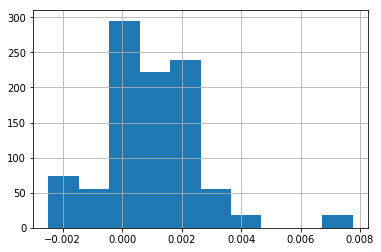

In [64]:
industry = '65623000'
c= pred_state_openrate(industry,10)
a =sm_em_chg[industry]
a.hist(bins=10, density=True, label = 'Counts')


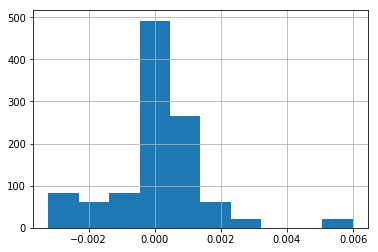

In [65]:
cs = pd.Series(c)
cs.hist(bins=10, density=True, label = 'Counts')

In [66]:
import dill
def predict_industry_opening_state():
    pred =  dill.load(open('pred_national_ts.dill', 'rb'))
    count = 0
    for ind_code in pred.columns.values:

        count +=1
        sm_industry = ind_match[ind_match.bd_industry == ind_code].sm_industry.values[0]
       # print(ind_code, sm_industry)
        c = pred_state_openrate(sm_industry)

        if count ==1:
            state_ind_open = c.rename(sm_industry)
        else:
            state_ind_open = pd.concat([state_ind_open,  c.rename(sm_industry)], axis=1)
    
    dill.dump(state_ind_open, open('state_ind_open' +'.dill', 'wb'))


In [67]:
predict_industry_opening_state()

In [68]:
state_ind_open = dill.load(open('state_ind_open.dill','rb'))
state_ind_open.head()

,43220000,10211000,10212000,10213000,20236000,20237000,20238000,32311000,32312000,32313000,...,65623000,65624000,70711000,70712000,70713000,70721000,70722000,80811000,80812000,80813000
01,-0.002591,0.00000,1.527830e-07,0.000000,0.005183,-0.015458,-0.004298,-0.000743,0.000000,0.004180,...,-0.000151,-0.001659,0.000000,0.000000,0.000764,0.000000,-0.003474,0.000000,0.00000,0.000000
02,0.000262,0.00000,0.000000e+00,0.003156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000872,0.000000,0.000000,0.000000,0.000000,0.027975,-0.004813,0.000000,0.00000,0.000000
04,0.000000,0.00000,0.000000e+00,0.000000,0.007936,-0.010645,0.002896,0.000000,0.000000,0.000000,...,0.005987,0.002377,0.000000,0.000000,0.000000,-0.004362,0.000543,0.000000,0.00000,0.000000
05,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,-0.000701,0.000000,0.000000,0.000000,...,0.000000,-0.001659,0.000000,0.000000,0.000000,-0.004362,-0.000796,0.000000,0.00000,0.000000
06,0.001213,-0.00123,-6.792873e-04,-0.003721,-0.005830,-0.015458,-0.004298,-0.002040,-0.000738,-0.004379,...,0.000872,0.002377,0.000949,-0.002281,-0.006533,-0.004362,0.000543,-0.003774,-0.00076,-0.001073


In [69]:
# function to predict the occupation openings at state level
import math

def predict_occupation_opening(occup_code):   
    pred = dill.load(open('pred_national_ts.dill', 'rb'))
    state_ind_open = dill.load(open('state_ind_open.dill','rb'))

    total_occup_nation = 0
    for ind_code in pred.columns.values:
        sm_industry = ind_match[ind_match.bd_industry == ind_code].sm_industry.values[0]
        oe_industry = ind_match[ind_match.bd_industry == ind_code].oe_industry.values[0]
       
        # ratio of occupation in all occupations in industry i
        ratio = oe_eng.loc[occup_code][oe_industry]/oe_eng.loc['000000'][oe_industry]

        # total occupation nationwide  = sum (opening in industry i * ratio)
        total_occup_nation += pred[ind_code] * ratio
        
    
    
    count = 0
    for state in sm_in.columns.values:
        state_name = bd_state[bd_state.state_code==state].state_name.values[0]
        if state !='00' and state !='78':
            count +=1
            openingrate = 0
            for ind_code in pred.columns.values:
                sm_industry = ind_match[ind_match.bd_industry == ind_code].sm_industry.values[0]
                oe_industry = ind_match[ind_match.bd_industry == ind_code].oe_industry.values[0]
                              
                # fluctuation is related to the employment increase rate of the state 
                # (economic strong)               
                fluctuation =  [state_ind_open.loc[state][sm_industry]]*len(pred[ind_code])
                
                # percent of occupation from industry i
                percent = oe_eng.loc[occup_code][oe_industry]/oe_eng.loc[occup_code]['000001']
                
                # opening rate=(opening rate in industry i nationwide + fluctuation) * percent
                # note that the employment in SM dataset is measured in thousands of workers
                openingrate += (pred[ind_code]/(sm_in.loc[sm_industry]['00']*1000) +fluctuation) \
                                 * percent 

                
            # opening at state is the current occupation * opening rate 
            ems_matrix_state = state +'00000'
            opening = ems_matrix.loc[occup_code][ems_matrix_state]*openingrate
            if ems_matrix.loc[occup_code][ems_matrix_state]==0 :
                openingrate = 0*openingrate

            if count ==1:
                occup_pred = opening.rename(state_name)
                open_rate = openingrate.rename(state_name)
            else:
                occup_pred = pd.concat([occup_pred, opening.rename(state_name)], axis=1)
                open_rate = pd.concat([open_rate, openingrate.rename(state_name)], axis=1)
                
    # normalize the total opening in all states so that the sum is still
    # equal to total occupation opening nation wide    
    occup_pred['sum_occup'] = occup_pred.sum(axis=1)
    occup_pred['baseline'] = total_occup_nation
    
    # ajust each column
    aratio = occup_pred['baseline']/occup_pred['sum_occup']
    for state in occup_pred.columns.values:
        if state != 'sum_occup' and state != 'baseline':
            occup_pred[state] = (occup_pred[state] * aratio).apply(int)
            open_rate[state] = open_rate[state] * aratio
    
    occup_pred = occup_pred.sort_values(by = occup_pred.last_valid_index() ,axis = 1, ascending = False)
    open_rate = open_rate.sort_values(by = open_rate.last_valid_index() ,axis = 1, ascending = False)

    #occup_pred = occup_pred.apply(int) 
    dill.dump(occup_pred, open('occup_pred_' + occup_code+'.dill', 'wb'))
    dill.dump(open_rate, open('occup_opening_rate_' + occup_code+'.dill', 'wb'))

In [78]:
predict_occupation_opening('172011')

In [22]:
import dill
pred = dill.load(open('occup_pred_172011.dill','rb'))
pred.head()

,sum_occup,baseline,California,Texas,Alabama,Ohio,Maryland,Florida,Georgia,Colorado,...,Arkansas,Iowa,North Dakota,South Dakota,South Carolina,Rhode Island,Maine,Missouri,Montana,New Hampshire
2018-06-30,2369.482560,2219.507799,442,282,186,162,110,98,94,93,...,0,0,0,0,0,0,0,0,0,0
2018-09-30,2333.310955,2184.146673,435,278,183,159,108,96,93,91,...,0,0,0,0,0,0,0,0,0,0
2018-12-31,2303.616369,2161.679180,430,275,181,157,107,95,92,91,...,0,0,0,0,0,0,0,0,0,0
2019-03-31,2276.692879,2132.451560,425,271,179,155,105,94,90,89,...,0,0,0,0,0,0,0,0,0,0
2019-06-30,2325.896943,2181.009247,434,277,183,159,108,96,92,91,...,0,0,0,0,0,0,0,0,0,0


In [24]:
pred.tail(4).sum().head(5)

sum_occup     9166.034719
baseline      8597.491134
California    1712.000000
Texas         1093.000000
Alabama        721.000000
dtype: float64

In [23]:
pred_rate= dill.load(open('occup_opening_rate_172011.dill','rb'))
pred_rate.head(2)

,Texas,Alabama,Maryland,Puerto Rico,Colorado,Arizona,Tennessee,Kansas,Illinois,Nevada,...,South Carolina,Rhode Island,North Dakota,New Hampshire,Alaska,Missouri,Arkansas,Maine,Iowa,Montana
2018-06-30,0.040192,0.040029,0.039641,0.039512,0.039423,0.039231,0.039164,0.039042,0.038972,0.038859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-09-30,0.039575,0.039412,0.039025,0.038896,0.038806,0.038614,0.038548,0.038425,0.038356,0.038243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
pred_rate.tail(4).mean().head(3)

Texas       0.038972
Alabama     0.038809
Maryland    0.038421
dtype: float64


For example, Aerospace engineer (172011) openings, the top states for openings are 

California (1712 per year), Texas (1093 per year), Alabama (721 per year)

However, if consider the employment population, the following states actually provide highest job opening per 1000 employment:

Texas (3.9%), Alabama (3.9%),  Maryland (3.8%)

# 5.0 Prediction Results

In [90]:
occupation_dict = {'172011':'Aerospace', '172031':'Biomedical','172041':'Chemical',\
                   '172051':'Civil', '172061':'Computer-Hardware', '172071':'Electrical',\
                   '172072':'Electronics', '172081':'Environmental', '172111': 'Health-and-Safety',\
                   '172131':'Material', '172141':'Mechanical'}

# remove '172110':'Industrial', no state level data for industrial eng
open_dict = {}
for occupation, title in occupation_dict.items():
    print(title)
    predict_occupation_opening(occupation)
    pred = dill.load(open('occup_pred_'+ occupation +'.dill','rb'))
    top3states= pred.tail(4).sum().head(10).index[2:5].values
    top3opening = pred.tail(4).sum().head(10).tolist()[2:5]
    val = [(st,int(op)) for st,op in zip(top3states,top3opening)]
    open_dict[title+ ' Engineer']= val
    print(title, val)

dill.dump(open_dict, open('eng_open_predict.dill', 'wb'))
import pickle
with open('eng_open_predict.pkl', 'wb') as pickle_file:
    pickle.dump(open_dict, pickle_file)

Aerospace
Aerospace [('California', 1712), ('Texas', 1093), ('Alabama', 721)]
Biomedical
Biomedical [('California', 601), ('Massachusetts', 363), ('Illinois', 187)]
Chemical
Chemical [('Texas', 1265), ('California', 347), ('Louisiana', 341)]
Civil
Civil [('California', 8921), ('Texas', 5733), ('Florida', 3489)]
Computer-Hardware
Computer-Hardware [('California', 4119), ('Maryland', 738), ('Colorado', 679)]
Electrical
Electrical [('California', 3834), ('Texas', 2293), ('New York', 1658)]
Electronics
Electronics [('California', 4160), ('Texas', 1894), ('Colorado', 895)]
Environmental
Environmental [('California', 1380), ('New York', 539), ('Pennsylvania', 520)]
Health-and-Safety
Health-and-Safety [('Texas', 650), ('California', 506), ('New York', 385)]
Material
Material [('California', 444), ('Texas', 392), ('Ohio', 247)]
Mechanical
Mechanical [('Michigan', 7413), ('California', 4278), ('Texas', 3370)]
